For the third assignment, we implemented some modifications with regard to the first and second assignment.

1. Assignment 1

In assignment 1, we used forward selection for our GLM model construction. This was a long process, especially as we considered all possible options. In this third assignment, we implemented Lasso regularization as another variable selection method.

2. Assignment 2

We added clustering and some interpretability tools.

Authors: Natalie Ameloot & Fabio Li Crapi.


#### Import the assignment data 

In [ ]:
import time
import random
import math
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import metrics
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

import scipy.stats as ss # added to compute confusion matrix
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.compose import ColumnTransformer
!pip install feature_engine
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from matplotlib import pyplot
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

!pip install sklearn-gbmi --no-cache-dir


!pip install PyALE
!pip install lime
!pip install shap

from sklearn.utils import validation

import time

from PyALE import ale
import lime
import lime.lime_tabular
import shap

my_data = pd.read_csv("https://gitfront.io/r/katrienantonio/a29071bdc7b2f20f24268be573ef54b68c65168c/IABE-DS-module-1/raw/assignment/assignment_data.csv", delimiter = ",")
my_data.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


AGEPH  CODPOSS     duree    lnexpo  nbrtotc   nbrtotan    chargtot agecar  \
0     64     1000  1.000000  0.000000        0   0.000000    0.000000    2-5   
1     28     1000  0.046575 -3.066684        1  21.470588  155.974606   6-10   
2     58     1000  0.402740 -0.909465        0   0.000000    0.000000    >10   
3     37     1030  0.169863 -1.772763        0   0.000000    0.000000    2-5   
4     29     1030  1.000000  0.000000        0   0.000000    0.000000   6-10   

     sexp   fuelc   split          usec fleetc sportc   coverp  powerc  
0  Female  Petrol    Once       Private     No     No    MTPL+  66-110  
1  Female  Petrol   Twice       Private     No     No     MTPL  66-110  
2  Female  Petrol  Thrice       Private     No     No     MTPL     <66  
3  Female  Petrol    Once  Professional     No     No  MTPL+++  66-110  
4  Female  Petrol    Once       Private     No     No    MTPL+     <66

In [ ]:
print(my_data.loc[1])
print(my_data.dtypes)

AGEPH               28
CODPOSS           1000
duree         0.046575
lnexpo       -3.066684
nbrtotc              1
nbrtotan     21.470588
chargtot    155.974606
agecar            6-10
sexp            Female
fuelc           Petrol
split            Twice
usec           Private
fleetc              No
sportc              No
coverp            MTPL
powerc          66-110
Name: 1, dtype: object
AGEPH         int64
CODPOSS       int64
duree       float64
lnexpo      float64
nbrtotc       int64
nbrtotan    float64
chargtot    float64
agecar       object
sexp         object
fuelc        object
split        object
usec         object
fleetc       object
sportc       object
coverp       object
powerc       object
dtype: object


#### GLM Lasso


**Retreatment of variables from Assignment 1 when we perform GLM**

In [ ]:
my_data['AGEPH_cat'] = np.where(my_data['AGEPH'] < 20, "17", np.where(my_data['AGEPH'] < 23 ,"20", \
                              np.where(my_data['AGEPH'] < 26, "23", np.where(my_data['AGEPH'] < 31, "26", \
                              np.where(my_data['AGEPH'] < 36, "31", np.where(my_data['AGEPH'] < 41, "36", \
                              np.where(my_data['AGEPH'] < 46, "41", np.where(my_data['AGEPH'] < 51, "46", \
                              np.where(my_data['AGEPH'] < 56, "51", np.where(my_data['AGEPH'] < 61, "56", \
                              np.where(my_data['AGEPH'] < 66, "61", np.where(my_data['AGEPH'] < 71, "66", \
                              np.where(my_data['AGEPH'] < 76, "71", np.where(my_data['AGEPH'] < 81, "76", "81"))))))))))))))

my_data['agecar'] = np.where(my_data['agecar'] == "0-1", "0", np.where(my_data['agecar'] == "2-5" ,"2", \
                              np.where(my_data['agecar'] == "6-10", "6", "11")))
print(my_data.agecar.value_counts().sort_index())
my_data['coverp'] = np.where(my_data['coverp'] == "MTPL", "MTPL", np.where(my_data['coverp'] == "MTPL+" ,"MTPLp", "MTPLppp"))
my_data.coverp.value_counts()
my_data['powerc'] = np.where(my_data['powerc'] == "<66", "0", np.where(my_data['powerc'] == "66-110" ,"66", "111"))
my_data.powerc.value_counts()
for c in ["AGEPH","CODPOSS","agecar","sexp","fuelc","split","usec","fleetc","sportc","coverp","powerc","AGEPH_cat"]:
    my_data[c]=pd.Categorical(my_data[c])

my_data["split"] = my_data["split"].cat.reorder_categories(['Once','Twice','Thrice','Monthly'])
my_data["powerc"] = my_data["powerc"].cat.reorder_categories(['0','66','111'])
my_data["agecar"] = my_data["agecar"].cat.reorder_categories(['0','2','6','11'])

my_data.info()

0      7766
11    37181
2     51559
6     67151
Name: agecar, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163657 entries, 0 to 163656
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   AGEPH      163657 non-null  category
 1   CODPOSS    163657 non-null  category
 2   duree      163657 non-null  float64 
 3   lnexpo     163657 non-null  float64 
 4   nbrtotc    163657 non-null  int64   
 5   nbrtotan   163657 non-null  float64 
 6   chargtot   163657 non-null  float64 
 7   agecar     163657 non-null  category
 8   sexp       163657 non-null  category
 9   fuelc      163657 non-null  category
 10  split      163657 non-null  category
 11  usec       163657 non-null  category
 12  fleetc     163657 non-null  category
 13  sportc     163657 non-null  category
 14  coverp     163657 non-null  category
 15  powerc     163657 non-null  category
 16  AGEPH_cat  163657 non-null  category
dtypes: category

**Split train-test set and one hot encoding**

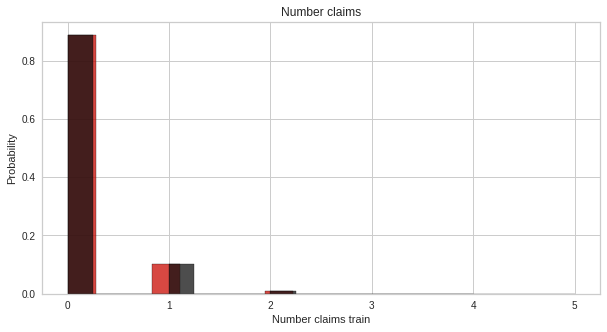

In [ ]:
np.random.seed(123)

bins = np.linspace(my_data.nbrtotc.min(),my_data.nbrtotc.max(), 20 ) 
y_cat = pd.cut(my_data.nbrtotc,bins=bins,include_lowest=True) 
my_data_X = my_data.drop(labels=['CODPOSS','lnexpo','nbrtotc','nbrtotan','chargtot'], axis=1) 
my_data_X_train, my_data_X_test, my_data_y_train, my_data_y_test = train_test_split(my_data_X, my_data.nbrtotc, test_size=0.2, stratify=y_cat)

X_train=my_data_X_train
y_train=my_data_y_train
Duree_train=my_data_X_train['duree']
X_train_1=X_train.drop(labels=['duree'],axis=1)
AGEPH_train=my_data_X_train['AGEPH']
X_train_2=X_train_1.drop(labels=['AGEPH'],axis=1)
X_train_3=pd.get_dummies(data=X_train_2,drop_first=True)

train=X_train_3
train["duree"]=Duree_train
train["nbrtotc"]=y_train
train["AGEPH"]=AGEPH_train

X_test=my_data_X_test
y_test=my_data_y_test
Duree_test=my_data_X_test['duree']
X_test_1=X_test.drop(labels=['duree'],axis=1)
AGEPH_test=my_data_X_test['AGEPH']
X_test_2=X_test_1.drop(labels=['AGEPH'],axis=1)
X_test_3=pd.get_dummies(data=X_test_2,drop_first=True)

test=X_test_3
test["duree"]=Duree_test
test["nbrtotc"]=y_test
test["AGEPH"]=AGEPH_test

#create dataframe from different vector lengths
df1= pd.DataFrame(my_data_y_train)
df2= pd.DataFrame(my_data_y_test)
plot_pd = pd.concat([df1,df2], ignore_index=True, axis=1)
#rename columns for x-label
plot_pd.columns = ['Number claims train', 'Number claims test']
#plot 
fig, axs = plt.subplots(ncols=1, figsize=(10,5));
sns.histplot(plot_pd['Number claims train'], ax = axs, color='r',stat="probability").set(title='Number claims');
sns.histplot(plot_pd['Number claims test'], ax = axs, color='k',stat="probability");
plt.show()

**A first model**

We implement a Lasso regularized Poisson model with penalty weight $\alpha$ 0.01.

In [ ]:
freq_glm_reg1 = smf.glm('nbrtotc ~ agecar_2 + agecar_6 + agecar_11 + sexp_Male + fuelc_Petrol + split_Twice + split_Thrice + split_Monthly + usec_Professional + fleetc_Yes + sportc_Yes + coverp_MTPLp + coverp_MTPLppp + powerc_66 + powerc_111 + AGEPH_cat_20 + AGEPH_cat_23 + AGEPH_cat_26 + AGEPH_cat_31 + AGEPH_cat_36 + AGEPH_cat_41 + AGEPH_cat_46 + AGEPH_cat_51 + AGEPH_cat_56 + AGEPH_cat_61 + AGEPH_cat_66 + AGEPH_cat_71 + AGEPH_cat_76 + AGEPH_cat_81',
                       data=train, exposure=train.duree, family=sm.families.Poisson(link=sm.families.links.log())).fit_regularized(method='elastic_net',alpha = 0.01,L1_wt = 1)

Elastic net fitting did not converge


In [ ]:
freq_glm_reg1.params

Intercept           -1.848958
agecar_2             0.000000
agecar_6             0.000000
agecar_11            0.000000
sexp_Male            0.000000
fuelc_Petrol        -0.064020
split_Twice          0.000000
split_Thrice         0.000000
split_Monthly        0.000000
usec_Professional    0.000000
fleetc_Yes           0.000000
sportc_Yes           0.000000
coverp_MTPLp         0.000000
coverp_MTPLppp       0.000000
powerc_66            0.000000
powerc_111           0.000000
AGEPH_cat_20         0.000000
AGEPH_cat_23         0.000000
AGEPH_cat_26         0.000000
AGEPH_cat_31         0.000000
AGEPH_cat_36         0.000000
AGEPH_cat_41         0.000000
AGEPH_cat_46         0.000000
AGEPH_cat_51         0.000000
AGEPH_cat_56         0.000000
AGEPH_cat_61         0.000000
AGEPH_cat_66         0.000000
AGEPH_cat_71         0.000000
AGEPH_cat_76         0.000000
AGEPH_cat_81         0.000000
dtype: float64

**Optimization of $\alpha$**

We first explore the impact of the penalty weight $\alpha$.

In [ ]:
alpha_grid = [0, 0.0001, 0.001, 0.01, 0.1]
coef_list = []
for alpha in alpha_grid:
  print(f"Busy with alpha:{alpha}")
  glm_reg_fit = smf.glm('nbrtotc ~ agecar_2 + agecar_6 + agecar_11 + sexp_Male + fuelc_Petrol + split_Twice + split_Thrice + split_Monthly + usec_Professional + fleetc_Yes + sportc_Yes + coverp_MTPLp + coverp_MTPLppp + powerc_66 + powerc_111 + AGEPH_cat_20 + AGEPH_cat_23 + AGEPH_cat_26 + AGEPH_cat_31 + AGEPH_cat_36 + AGEPH_cat_41 + AGEPH_cat_46 + AGEPH_cat_51 + AGEPH_cat_56 + AGEPH_cat_61 + AGEPH_cat_66 + AGEPH_cat_71 + AGEPH_cat_76 + AGEPH_cat_81',
                       data=train, exposure=train.duree, family=sm.families.Poisson(link=sm.families.links.log())).fit_regularized(method='elastic_net',alpha = alpha,L1_wt = 1)
  coef_list.append(glm_reg_fit.params)   
pd_coef = pd.concat(coef_list, axis = 1)

Busy with alpha:0
Busy with alpha:0.0001
Busy with alpha:0.001
Busy with alpha:0.01
Busy with alpha:0.1


In [ ]:
pd_coef.columns = alpha_grid
pd_coef

0.0000    0.0001    0.0010    0.0100    0.1000
Intercept         -0.878335 -1.363851 -1.868510 -1.848958 -1.379186
agecar_2          -0.284278 -0.256185 -0.085302  0.000000  0.000000
agecar_6          -0.214561 -0.184368  0.000000  0.000000  0.000000
agecar_11         -0.211486 -0.182983  0.000000  0.000000  0.000000
sexp_Male         -0.041001 -0.045445 -0.039563  0.000000  0.000000
fuelc_Petrol      -0.169335 -0.174485 -0.159022 -0.064020  0.000000
split_Twice        0.176350  0.172015  0.000000  0.000000  0.000000
split_Thrice       0.399530  0.395997  0.273868  0.000000  0.000000
split_Monthly      0.376802  0.369349  0.231271  0.000000  0.000000
usec_Professional  0.015280  0.000000  0.000000  0.000000  0.000000
fleetc_Yes        -0.083105 -0.067784  0.000000  0.000000  0.000000
sportc_Yes         0.053792  0.004649  0.000000  0.000000  0.000000
coverp_MTPLp      -0.105668 -0.102854 -0.054049  0.000000  0.000000
coverp_MTPLppp    -0.133680 -0.118197  0.000000  0.000000  0.000000
powerc_66          0.097529  0.095419  0.000000  0.000000  0.000000
powerc_111         0.173161  0.104756  0.000000  0.000000  0.000000
AGEPH_cat_20      -0.200227  0.231188  0.250000  0.000000  0.000000
AGEPH_cat_23      -0.315852  0.138954  0.425742  0.000000  0.000000
AGEPH_cat_26      -0.545459 -0.072668  0.269303  0.000000  0.000000
AGEPH_cat_31      -0.780126 -0.306767  0.000000  0.000000  0.000000
AGEPH_cat_36      -0.878317 -0.404428  0.000000  0.000000  0.000000
AGEPH_cat_41      -0.853729 -0.380337  0.000000  0.000000  0.000000
AGEPH_cat_46      -0.886018 -0.412403  0.000000  0.000000  0.000000
AGEPH_cat_51      -0.933553 -0.457581  0.000000  0.000000  0.000000
AGEPH_cat_56      -1.024807 -0.545444 -0.053917  0.000000  0.000000
AGEPH_cat_61      -1.119403 -0.637524 -0.131214  0.000000  0.000000
AGEPH_cat_66      -1.091509 -0.608762 -0.106961  0.000000  0.000000
AGEPH_cat_71      -1.101922 -0.611652 -0.062526  0.000000  0.000000
AGEPH_cat_76      -1.085653 -0.568930  0.000000  0.000000  0.000000
AGEPH_cat_81      -0.889686  0.000000  0.000000  0.000000  0.000000

We use 10-fold stratified CV and the one-standard-error rule to determine the optimal value for $\alpha$.

In [ ]:
alpha = [0, 0.0001, 0.0008, 0.0009, 0.0010, 0.0100, 0.1000]
alpha

[0, 0.0001, 0.0008, 0.0009, 0.001, 0.01, 0.1]

In [ ]:
num_k_fold = 10
scores = pd.DataFrame(columns = ['Alpha', 'Mean deviance (testing)', 'Mean deviance (training)'],
                      data = np.zeros((num_k_fold * len(alpha), 3)))

# Loop over the number of trees
for j in range(len(alpha)):
    print(f"Busy with alpha:{alpha[j]}")
    i = 0
    
    # Initiate k-fold object
    kf = StratifiedKFold(n_splits= num_k_fold)
    
    # k-fold cross-validation for the selected number of trees
    for trainI, testI in kf.split(train,y_train):
        # Select training and testing subsets
        
        train_cv, y_train_cv = train.iloc[trainI], y_train.iloc[trainI]
        test_cv, y_test_cv = train.iloc[testI], y_train.iloc[testI]
       
        # Training
        glm_reg_fit = smf.glm('nbrtotc ~ agecar_2 + agecar_6 + agecar_11 + sexp_Male + fuelc_Petrol + split_Twice + split_Thrice + split_Monthly + usec_Professional + fleetc_Yes + sportc_Yes + coverp_MTPLp + coverp_MTPLppp + powerc_66 + powerc_111 + AGEPH_cat_20 + AGEPH_cat_23 + AGEPH_cat_26 + AGEPH_cat_31 + AGEPH_cat_36 + AGEPH_cat_41 + AGEPH_cat_46 + AGEPH_cat_51 + AGEPH_cat_56 + AGEPH_cat_61 + AGEPH_cat_66 + AGEPH_cat_71 + AGEPH_cat_76 + AGEPH_cat_81',
                       data=train_cv, exposure=train_cv.duree, family=sm.families.Poisson(link=sm.families.links.log())).fit_regularized(method='elastic_net',alpha = alpha[j],L1_wt = 1)

        # Prediction
        y_pred_train_cv = glm_reg_fit.predict(train_cv, exposure = train_cv.duree)
        y_pred_test_cv = glm_reg_fit.predict(test_cv, exposure = test_cv.duree)

        # Metrics
        index = j * num_k_fold + i
        scores.at[index, 'Alpha'] = alpha[j]
        scores.at[index, 'Mean deviance (testing)'] = mean_poisson_deviance(np.array(test_cv.nbrtotc),np.array(y_pred_test_cv))
        scores.at[index, 'Mean deviance (training)'] = mean_poisson_deviance(np.array(train_cv.nbrtotc),np.array(y_pred_train_cv))
        i = i + 1

Busy with alpha:0


The least populated class in y has only 2 members, which is less than n_splits=10.
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge


Busy with alpha:0.0001


The least populated class in y has only 2 members, which is less than n_splits=10.
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge


Busy with alpha:0.0008


The least populated class in y has only 2 members, which is less than n_splits=10.
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge


Busy with alpha:0.0009


The least populated class in y has only 2 members, which is less than n_splits=10.
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge


Busy with alpha:0.001


The least populated class in y has only 2 members, which is less than n_splits=10.
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge


Busy with alpha:0.01


The least populated class in y has only 2 members, which is less than n_splits=10.
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge
Elastic net fitting did not converge


Busy with alpha:0.1


The least populated class in y has only 2 members, which is less than n_splits=10.


In [ ]:
gp = scores.groupby('Alpha')
means = gp.mean()
means

Mean deviance (testing)  Mean deviance (training)
Alpha                                                    
0.0000                 0.539093                  0.538505
0.0001                 0.539376                  0.538735
0.0008                 0.540748                  0.540327
0.0009                 0.541123                  0.540685
0.0010                 0.541844                  0.541398
0.0100                 0.551235                  0.551226
0.1000                 0.604320                  0.604320

In [ ]:
gp = scores.groupby('Alpha')
std = gp.std()
std

Mean deviance (testing)  Mean deviance (training)
Alpha                                                    
0.0000                 0.002469                  0.000271
0.0001                 0.002432                  0.000296
0.0008                 0.001923                  0.000351
0.0009                 0.002137                  0.000295
0.0010                 0.001955                  0.000479
0.0100                 0.001892                  0.000191
0.1000                 0.002001                  0.000217

The optimal value for $\alpha$ is the biggest value with mean error less than 0.539093 + 0.002469 = 0.541562. This value is 0.0009.

In [ ]:
freq_glm_reg = smf.glm('nbrtotc ~ agecar_2 + agecar_6 + agecar_11 + sexp_Male + fuelc_Petrol + split_Twice + split_Thrice + split_Monthly + usec_Professional + fleetc_Yes + sportc_Yes + coverp_MTPLp + coverp_MTPLppp + powerc_66 + powerc_111 + AGEPH_cat_20 + AGEPH_cat_23 + AGEPH_cat_26 + AGEPH_cat_31 + AGEPH_cat_36 + AGEPH_cat_41 + AGEPH_cat_46 + AGEPH_cat_51 + AGEPH_cat_56 + AGEPH_cat_61 + AGEPH_cat_66 + AGEPH_cat_71 + AGEPH_cat_76 + AGEPH_cat_81',
                       data=train, exposure=train.duree, family=sm.families.Poisson(link=sm.families.links.log())).fit_regularized(method='elastic_net',alpha = 0.0009,L1_wt = 1)

Elastic net fitting did not converge


In [ ]:
freq_glm_reg.params

Intercept           -1.916094
agecar_2            -0.086808
agecar_6             0.000000
agecar_11            0.000000
sexp_Male           -0.043696
fuelc_Petrol        -0.163340
split_Twice          0.116191
split_Thrice         0.327515
split_Monthly        0.281859
usec_Professional    0.000000
fleetc_Yes           0.000000
sportc_Yes           0.000000
coverp_MTPLp        -0.065304
coverp_MTPLppp      -0.007187
powerc_66            0.041458
powerc_111           0.000000
AGEPH_cat_20         0.297758
AGEPH_cat_23         0.437400
AGEPH_cat_26         0.270090
AGEPH_cat_31         0.000000
AGEPH_cat_36         0.000000
AGEPH_cat_41         0.000000
AGEPH_cat_46         0.000000
AGEPH_cat_51         0.000000
AGEPH_cat_56        -0.057543
AGEPH_cat_61        -0.134394
AGEPH_cat_66        -0.104714
AGEPH_cat_71        -0.061529
AGEPH_cat_76         0.000000
AGEPH_cat_81         0.000000
dtype: float64

From the Lasso model, we conclude that we can drop the variables usec, fleetc and sportc to construct a classic GLM model. There is one variable, sexp, that has a coefficient not set to zero during Lasso regularization but that wasn't retained using forward variable selection (section 1.a) from assignment 1. The coefficient however for sexp after Lasso regularization is small, -0.043696.


#### Clustering


In this section we we will apply PCA in order to cluster the transformed data with K-Means

In [ ]:
# We will cluster policyholders based on a subset of features
policy_characteristics = my_data[["coverp", "fuelc", "usec", "fleetc", "agecar", 'AGEPH',"sexp","sportc"]]

We start by converting our data to numerical features. For this we one-hot encode our categorical features.

In [ ]:

EOH = OneHotEncoder(handle_unknown='ignore')

categorical_features = np.concatenate((
    EOH.fit_transform(policy_characteristics[["coverp"]]).toarray(),
    EOH.fit_transform(policy_characteristics[["fuelc"]]).toarray(),
    EOH.fit_transform(policy_characteristics[["usec"]]).toarray(),
    EOH.fit_transform(policy_characteristics[["fleetc"]]).toarray(),
    EOH.fit_transform(policy_characteristics[["agecar"]]).toarray(),
    EOH.fit_transform(policy_characteristics[["sexp"]]).toarray(),
    EOH.fit_transform(policy_characteristics[["sportc"]]).toarray()
    ), axis = 1)

categorical_label = np.concatenate((
    EOH.fit(policy_characteristics[["coverp"]]).categories_,
    EOH.fit(policy_characteristics[["fuelc"]]).categories_,
    EOH.fit(policy_characteristics[["usec"]]).categories_,
    EOH.fit(policy_characteristics[["fleetc"]]).categories_,
    EOH.fit(policy_characteristics[["agecar"]]).categories_,
    EOH.fit(policy_characteristics[["sexp"]]).categories_,
    EOH.fit(policy_characteristics[["sportc"]]).categories_,
    ), axis = 1)

In [ ]:
features = np.concatenate((categorical_features, 
                           my_data[["AGEPH"]].to_numpy()), axis = 1)

In [ ]:
label = np.concatenate((categorical_label[0,:], np.array(["AGEPH"])))

In [ ]:
label

array(['MTPL', 'MTPLp', 'MTPLppp', 'Gasoil', 'Petrol', 'Private',
       'Professional', 'No', 'Yes', '0', '11', '2', '6', 'Female', 'Male',
       'No', 'Yes', 'AGEPH'], dtype=object)

In [ ]:
features[0,:] # FIRST Line of DB

array([ 0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
        1.,  0.,  1.,  0., 64.])

Here we will standardize the data by substracting with the mean and divide by the standard deviation. 

In [ ]:
for col in range(features.shape[1]):
  features[:,col] = (features[:,col] - np.mean(features[:,col])) / np.std(features[:,col])

In [ ]:
print(features[0,:])

[-1.18235994  1.59753679 -0.3958961  -0.6675369   0.6675369   0.22677925
 -0.22677925  0.18167424 -0.18167424 -0.22319691 -0.5421962   1.47450649
 -0.83415947  1.66923354 -1.66923354  0.09656597 -0.09656597  1.14614822]


We fit a PCA model explaining 90% of the variation in the original data set

In [ ]:
pca = PCA(n_components=.9).fit(features)
pca.n_components_

9

In [ ]:
pca.n_features_in_

18

In [ ]:
features_pca = pca.transform(features)

We'll use  K-means to cluster our data . We will find the ideal number of clustering by using the elbow method

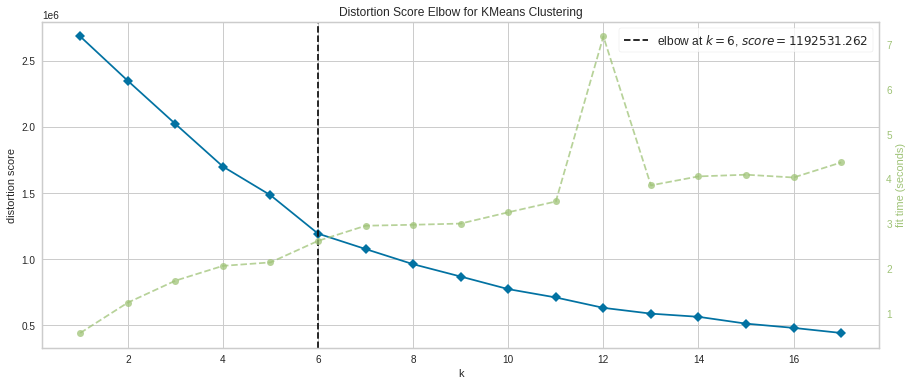

In [ ]:
np.random.seed(123)
visualizer = KElbowVisualizer(KMeans(), k=(1, 18))
visualizer.fit(features_pca)
visualizer.show()

The ideal number of cluster is 6 so we fit a Kmeans with 6 clusters

In [ ]:
km = KMeans(n_clusters = 6) 
km.fit(features_pca)

KMeans(n_clusters=6)

In [ ]:
print(label)

['MTPL' 'MTPLp' 'MTPLppp' 'Gasoil' 'Petrol' 'Private' 'Professional' 'No'
 'Yes' '0' '11' '2' '6' 'Female' 'Male' 'No' 'Yes' 'AGEPH']


In [ ]:
print(km.labels_)
print(features)

[0 0 0 ... 2 3 1]
[[-1.18235994  1.59753679 -0.3958961  ...  0.09656597 -0.09656597
   1.14614822]
 [ 0.84576614 -0.62596367 -0.3958961  ...  0.09656597 -0.09656597
  -1.28107905]
 [ 0.84576614 -0.62596367 -0.3958961  ...  0.09656597 -0.09656597
   0.74161034]
 ...
 [ 0.84576614 -0.62596367 -0.3958961  ...  0.09656597 -0.09656597
   1.14614822]
 [ 0.84576614 -0.62596367 -0.3958961  ...  0.09656597 -0.09656597
   0.74161034]
 [-1.18235994 -0.62596367  2.52591529 ...  0.09656597 -0.09656597
  -1.55077097]]


To inspect the contents of these clusters, we compute the average value of the (original) covariates in each cluster. We'll use this information later .

In [ ]:
avg_value_cluster = np.zeros(shape = (6, 18));
for idx in range(0, 6):
    avg_value_cluster[idx, :] = features[km.labels_ == idx, :].mean(axis = 0)

In [ ]:
label

array(['MTPL', 'MTPLp', 'MTPLppp', 'Gasoil', 'Petrol', 'Private',
       'Professional', 'No', 'Yes', '0', '11', '2', '6', 'Female', 'Male',
       'No', 'Yes', 'AGEPH'], dtype=object)

In [ ]:
label

array(['MTPL', 'MTPLp', 'MTPLppp', 'Gasoil', 'Petrol', 'Private',
       'Professional', 'No', 'Yes', '0', '11', '2', '6', 'Female', 'Male',
       'No', 'Yes', 'AGEPH'], dtype=object)

In [ ]:
print(km.labels_)

[0 0 0 ... 2 3 1]


In [ ]:
print(type(km.labels_))
print(km.labels_.size)

<class 'numpy.ndarray'>
163657


In [ ]:
print(my_data.head())

  AGEPH CODPOSS     duree    lnexpo  nbrtotc   nbrtotan    chargtot agecar  \
0    64    1000  1.000000  0.000000        0   0.000000    0.000000      2   
1    28    1000  0.046575 -3.066684        1  21.470588  155.974606      6   
2    58    1000  0.402740 -0.909465        0   0.000000    0.000000     11   
3    37    1030  0.169863 -1.772763        0   0.000000    0.000000      2   
4    29    1030  1.000000  0.000000        0   0.000000    0.000000      6   

     sexp   fuelc   split          usec fleetc sportc   coverp powerc  \
0  Female  Petrol    Once       Private     No     No    MTPLp     66   
1  Female  Petrol   Twice       Private     No     No     MTPL     66   
2  Female  Petrol  Thrice       Private     No     No     MTPL      0   
3  Female  Petrol    Once  Professional     No     No  MTPLppp     66   
4  Female  Petrol    Once       Private     No     No    MTPLp      0   

  AGEPH_cat  
0        61  
1        26  
2        56  
3        36  
4        26  


We add the cluster variable to our original data set

In [ ]:
my_data['Clusters'] = km.labels_.tolist()

In [ ]:
print(my_data.head())

  AGEPH CODPOSS     duree    lnexpo  nbrtotc   nbrtotan    chargtot agecar  \
0    64    1000  1.000000  0.000000        0   0.000000    0.000000      2   
1    28    1000  0.046575 -3.066684        1  21.470588  155.974606      6   
2    58    1000  0.402740 -0.909465        0   0.000000    0.000000     11   
3    37    1030  0.169863 -1.772763        0   0.000000    0.000000      2   
4    29    1030  1.000000  0.000000        0   0.000000    0.000000      6   

     sexp   fuelc   split          usec fleetc sportc   coverp powerc  \
0  Female  Petrol    Once       Private     No     No    MTPLp     66   
1  Female  Petrol   Twice       Private     No     No     MTPL     66   
2  Female  Petrol  Thrice       Private     No     No     MTPL      0   
3  Female  Petrol    Once  Professional     No     No  MTPLppp     66   
4  Female  Petrol    Once       Private     No     No    MTPLp      0   

  AGEPH_cat  Clusters  
0        61         0  
1        26         0  
2        56         

In [ ]:
def my_data_description(variable):
    
    Nbr = my_data[['nbrtotc']].groupby([my_data[variable]]).sum().reset_index()
    exp = my_data[['duree']].groupby([my_data[variable]]).sum().reset_index()
    obs = pd.merge(Nbr,exp)
    obs['Freq']=obs['nbrtotc']/obs['duree']
   
    return(obs)

In [ ]:
def my_data_description_plot(variable):

    plt.rcParams['figure.figsize'] = [15, 6]
    table_to_plot=table.loc[:,[variable,'duree','Freq']]
    table_to_plot.plot(kind='bar', secondary_y='duree', rot=0)
    plt.xticks(range(table_to_plot.shape[0]),list(table_to_plot.iloc[:,0]))
    plot=plt.show()
    
    return(plot)

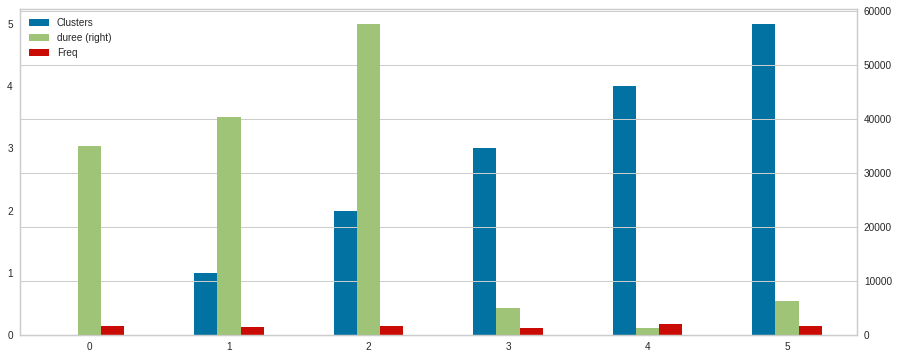

In [ ]:
table=my_data_description("Clusters")
my_data_description_plot("Clusters")

We see below that the cluster 4 and 0 seems to get higher claims frequency. We will investagate below the average values of this cluster to get an idea of these clusters. 

In [ ]:
print(table)

   Clusters  nbrtotc         duree      Freq
0         0     5235  35019.380822  0.149489
1         1     5147  40414.043836  0.127357
2         2     8228  57589.336986  0.142874
3         3      554   4954.865753  0.111809
4         4      229   1324.950685  0.172837
5         5      897   6317.150685  0.141994


In [ ]:
avg_value_cluster[4, :]

array([  0.13619028,  -0.04803002,  -0.13308766,  -0.64318843,
         0.64318843,  -0.0798579 ,   0.0798579 ,  -0.03268014,
         0.03268014,  -0.15786988,  -0.02763647,  -0.21262903,
         0.29257975,  -0.18352039,   0.18352039, -10.35561474,
        10.35561474,  -0.4840877 ])

In [ ]:
label

array(['MTPL', 'MTPLp', 'MTPLppp', 'Gasoil', 'Petrol', 'Private',
       'Professional', 'No', 'Yes', '0', '11', '2', '6', 'Female', 'Male',
       'No', 'Yes', 'AGEPH'], dtype=object)

It seems that sport Category represents well the cluster 4

In [ ]:
avg_value_cluster[0, :]

array([ 0.05412162, -0.03508474, -0.03186666, -0.17862727,  0.17862727,
        0.22677925, -0.22677925,  0.18167424, -0.18167424, -0.02009166,
        0.07105401, -0.06250512,  0.00718567,  1.66923354, -1.66923354,
        0.09656597, -0.09656597, -0.24945905])

The cluster 0 seems to be represented by female driver with private usage and with petrol fuel

In the next section we will use our models from assignment 2 : the random forest and XGboost to model the frequency . We will use our models (Xgboost and Random Forest ) to predict the frequency on our cluster just created before and we will compare the results. Then we will use some interpretability tools.

#### Xgboost

In this section we will take the Xgboost model from assignment 2.

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

We define below the deviance function to evaluate our model ( we will just check that we got the same results from assignment 2 with that)

In [ ]:
def DeviancePoisson_scikit(lambdahat,N,v):

    nlogn = np.array([np.nan for i in range(v.size)])
    dev = np.array([np.nan for i in range(v.size)])
    
    for i in range(v.size):
        if N[i]==0:
            nlogn[i] = 0
        else:
            nlogn[i] = N[i]*math.log(N[i]/(lambdahat[i]*v[i]))
            
        dev[i] = ( nlogn[i] - (N[i] - lambdahat[i]*v[i]) )
        
    return(dev.sum()/v.sum())

We'll use the function below to analyze frequency on clusters from the train/test set

In [ ]:
def my_data_description2( my_data, variable):
    
    Nbr = my_data[['nbrtotc']].groupby([my_data[variable]]).sum().reset_index()
    exp = my_data[['duree']].groupby([my_data[variable]]).sum().reset_index()
    obs = pd.merge(Nbr,exp)
    obs['Freq']=obs['nbrtotc']/obs['duree']
   
    return(obs)

Later we will use the function below to analyze the prediction from our model in a similar way than the observed frequency

In [ ]:
def my_data_description_predict( my_data, variable):
    
    Nbr = my_data[['pred_xgb']].groupby([my_data[variable]]).sum().reset_index()
    exp = my_data[['duree']].groupby([my_data[variable]]).sum().reset_index()
    obs = pd.merge(Nbr,exp)
    obs['Freq']=obs['pred_xgb']/obs['duree']
   
    return(obs)

We perform below the same preprocessing of data from assignment 2 ( splitting the train/test set with stratified method +  transform categorical data into dummies + visualisation)

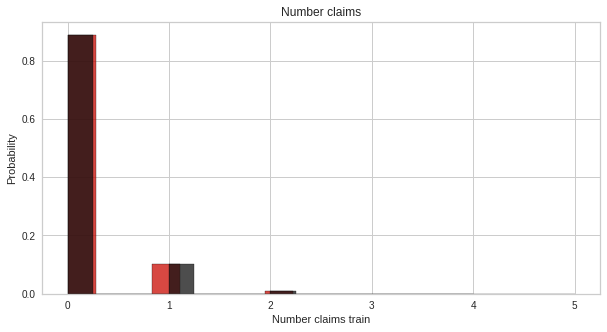

In [ ]:
np.random.seed(123)

my_data_X = my_data.drop(labels=['AGEPH_cat','CODPOSS','lnexpo','nbrtotc','nbrtotan','chargtot'], axis=1) 
my_data_X['AGEPH'] = my_data_X['AGEPH'].astype('int64')


my_data_X_train, my_data_X_test, my_data_y_train, my_data_y_test = train_test_split(my_data_X, my_data.nbrtotc, test_size=0.2, stratify=my_data.nbrtotc)


X_train=my_data_X_train
y_train=my_data_y_train
Duree_train=my_data_X_train['duree']
X_train_1=my_data_X_train.drop(labels=['duree'],axis=1)
X_train_2=pd.get_dummies(data=X_train_1,drop_first=True)
y_train_2=my_data_y_train/my_data_X_train['duree']

X_test=my_data_X_test
y_test=my_data_y_test
Duree_test=my_data_X_test['duree']
X_test_1=my_data_X_test.drop(labels=['duree'],axis=1)
X_test_2=pd.get_dummies(data=X_test_1,drop_first=True)
y_test_2=my_data_y_test/my_data_X_test['duree']

#create dataframe from different vector lengths
df1= pd.DataFrame(my_data_y_train)
df2= pd.DataFrame(my_data_y_test)
plot_pd = pd.concat([df1,df2], ignore_index=True, axis=1)
#rename columns for x-label
plot_pd.columns = ['Number claims train', 'Number claims test']
#plot 
fig, axs = plt.subplots(ncols=1, figsize=(10,5));
sns.histplot(plot_pd['Number claims train'], ax = axs, color='r',stat="probability").set(title='Number claims');
sns.histplot(plot_pd['Number claims test'], ax = axs, color='k',stat="probability");
plt.show()

In [ ]:
X_train_2.head(5)

AGEPH  Clusters  agecar_2  agecar_6  agecar_11  sexp_Male  \
28997      28         0         0         1          0          0   
25259      46         0         0         0          1          0   
135009     76         2         0         0          1          1   
121423     52         1         0         1          0          1   
116373     37         2         1         0          0          1   

        fuelc_Petrol  split_Twice  split_Thrice  split_Monthly  \
28997              1            0             0              0   
25259              1            0             0              0   
135009             1            0             0              0   
121423             0            0             0              0   
116373             0            1             0              0   

        usec_Professional  fleetc_Yes  sportc_Yes  coverp_MTPLp  \
28997                   0           0           0             1   
25259                   0           0           0             0   
135009                  0           0           0             0   
121423                  0           0           0             1   
116373                  0           0           0             0   

        coverp_MTPLppp  powerc_66  powerc_111  
28997                0          0           0  
25259                0          0           0  
135009               0          0           0  
121423               0          0           0  
116373               0          0           0

In [ ]:
cluster_train2=X_train_2['Clusters']
X_train_2 = X_train_2.drop(labels=['Clusters'], axis=1) 

In [ ]:
cluster_test2=X_test_2['Clusters']
X_test_2 = X_test_2.drop(labels=['Clusters'], axis=1) 

In [ ]:
y_mtpl_freq = np.array(y_train_2)
w_mtpl_freq = np.array(my_data_X_train['duree'])

We took below the XGB model we had optimized from assignment 2.

In [ ]:

xgb_frequency_opti = xgb.XGBRegressor(n_estimators = 100,
                                 objective='count:poisson',
                                 max_depth = 3,
                                 learning_rate = 0.09,
                                 base_score = np.sum(y_mtpl_freq * w_mtpl_freq)/np.sum(w_mtpl_freq))

xgb_frequency_opti.fit(X_train_2, y_train_2, sample_weight=w_mtpl_freq)

XGBRegressor(base_score=0.13938126247193397, learning_rate=0.09,
             objective='count:poisson')

Check on deviance 

In [ ]:
# Prediction
y_pred_train_xgb = xgb_frequency_opti.predict(X_train_2)
y_pred_test_xgb = xgb_frequency_opti.predict(X_test_2)

print("Poisson Deviance on training set:", DeviancePoisson_scikit(np.array(y_pred_train_xgb),np.array(y_train),np.array(my_data_X_train['duree'])))
print("Poisson Deviance on testing set:", DeviancePoisson_scikit(np.array(y_pred_test_xgb),np.array(y_test),np.array(my_data_X_test['duree'])))

Poisson Deviance on training set: 0.3012231665147244
Poisson Deviance on testing set: 0.3028855076423962


In [ ]:
X_train_2["pred_xgb"] = y_pred_train_xgb

In [ ]:

X_test_2["pred_xgb"] = y_pred_test_xgb

In [ ]:
X_train_2.head()

AGEPH  agecar_2  agecar_6  agecar_11  sexp_Male  fuelc_Petrol  \
28997      28         0         1          0          0             1   
25259      46         0         0          1          0             1   
135009     76         0         0          1          1             1   
121423     52         0         1          0          1             0   
116373     37         1         0          0          1             0   

        split_Twice  split_Thrice  split_Monthly  usec_Professional  \
28997             0             0              0                  0   
25259             0             0              0                  0   
135009            0             0              0                  0   
121423            0             0              0                  0   
116373            1             0              0                  0   

        fleetc_Yes  sportc_Yes  coverp_MTPLp  coverp_MTPLppp  powerc_66  \
28997            0           0             1               0          0   
25259            0           0             0               0          0   
135009           0           0             0               0          0   
121423           0           0             1               0          0   
116373           0           0             0               0          0   

        powerc_111  pred_xgb  
28997            0  0.136378  
25259            0  0.117563  
135009           0  0.077866  
121423           0  0.118921  
116373           0  0.149969

We put  on train and test set the nbrtotc variable

In [ ]:
X_train_2= X_train_2.join( my_data[list(['nbrtotc'])])

In [ ]:
X_test_2= X_test_2.join( my_data[list(['nbrtotc'])])

In [ ]:
X_train_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130925 entries, 28997 to 33454
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   AGEPH              130925 non-null  int64  
 1   agecar_2           130925 non-null  uint8  
 2   agecar_6           130925 non-null  uint8  
 3   agecar_11          130925 non-null  uint8  
 4   sexp_Male          130925 non-null  uint8  
 5   fuelc_Petrol       130925 non-null  uint8  
 6   split_Twice        130925 non-null  uint8  
 7   split_Thrice       130925 non-null  uint8  
 8   split_Monthly      130925 non-null  uint8  
 9   usec_Professional  130925 non-null  uint8  
 10  fleetc_Yes         130925 non-null  uint8  
 11  sportc_Yes         130925 non-null  uint8  
 12  coverp_MTPLp       130925 non-null  uint8  
 13  coverp_MTPLppp     130925 non-null  uint8  
 14  powerc_66          130925 non-null  uint8  
 15  powerc_111         130925 non-null  uint8  
 16 

We put the exposure and cluster on the train and test set 

In [ ]:
X_train_2["Clusters"] = cluster_train2
X_test_2["Clusters"] = cluster_test2


In [ ]:
X_train_2["duree"]=my_data_X_train['duree']
X_test_2["duree"]=my_data_X_test['duree']

Below the observed claim frequency on each clusters on the train and test set

In [ ]:
table_train2=my_data_description2( X_train_2,"Clusters")
print(table_train2)

   Clusters  nbrtotc         duree      Freq
0         0     4160  28026.391781  0.148432
1         1     4161  32428.235616  0.128314
2         2     6588  45920.783562  0.143464
3         3      441   3983.076712  0.110718
4         4      180   1045.323288  0.172196
5         5      705   5075.260274  0.138909


In [ ]:
table_test2=my_data_description2( X_test_2,"Clusters")
print(table_test2)

   Clusters  nbrtotc         duree      Freq
0         0     1075   6992.989041  0.153725
1         1      986   7985.808219  0.123469
2         2     1640  11668.553425  0.140549
3         3      113    971.789041  0.116280
4         4       49    279.627397  0.175233
5         5      192   1241.890411  0.154603


Now the goal is to use the test set in order to see if our model predict well the claim frequency for these clusters

In [ ]:
table_test_predict2= my_data_description_predict( X_test_2,"Clusters")

In [ ]:
print(table_test_predict2)

   Clusters     pred_xgb         duree      Freq
0         0  1194.850708   6992.989041  0.170864
1         1  1169.074951   7985.808219  0.146394
2         2  1908.949951  11668.553425  0.163598
3         3   116.078461    971.789041  0.119448
4         4    51.996243    279.627397  0.185948
5         5   193.092102   1241.890411  0.155482


#### Random Forest

In [ ]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import tree

In [ ]:
X_train_2 = X_train_2.drop(labels=['duree','Clusters', 'nbrtotc'], axis=1) 
X_train_2 = X_train_2.drop(labels=['pred_xgb'], axis=1) 
X_test_2 = X_test_2.drop(labels=['duree','Clusters', 'nbrtotc'], axis=1) 
X_test_2  =X_test_2 .drop(labels=['pred_xgb'], axis=1)

We import below the random Forest model we have fitted from assignment 2

In [ ]:
class_rf = RandomForestRegressor(n_estimators=115,
                                 max_depth=15,
                                 min_samples_leaf=450,
                                 criterion='poisson',max_features='sqrt',random_state = 0)

# Starting time
start = time.time()
# Training
reg_rf=class_rf.fit(X_train_2, y_train_2, sample_weight=my_data_X_train['duree'])
# Elapsed time
end = time.time()
print(end - start)

8.044275522232056


In [ ]:
# Prediction
y_pred_train = reg_rf.predict(X_train_2)
y_pred_test = reg_rf.predict(X_test_2)

print("Poisson Deviance on training set:", DeviancePoisson_scikit(np.array(y_pred_train),np.array(y_train),np.array(my_data_X_train['duree'])))
print("Poisson Deviance on testing set:", DeviancePoisson_scikit(np.array(y_pred_test),np.array(y_test),np.array(my_data_X_test['duree'])))

Poisson Deviance on training set: 0.3053591010362241
Poisson Deviance on testing set: 0.30575595531804095


We put the prediction, nbrtotc , cluster and exposure variable to the test set

In [ ]:
y_pred_test_rf= y_pred_test

In [ ]:
X_test_2["pred_xgb"] = y_pred_test_rf

In [ ]:
X_test_2= X_test_2.join( my_data[list(['nbrtotc'])])
X_test_2["Clusters"] = cluster_test2
X_test_2["duree"]=my_data_X_test['duree']


In [ ]:
table_test_predict= my_data_description_predict( X_test_2,"Clusters")

we see the results of our rf model frequency on our clusters

In [ ]:
print(table_test_predict)

   Clusters     pred_xgb         duree      Freq
0         0  1166.746205   6992.989041  0.166845
1         1  1171.288387   7985.808219  0.146671
2         2  1904.266466  11668.553425  0.163196
3         3   119.904834    971.789041  0.123386
4         4    45.283454    279.627397  0.161942
5         5   189.647624   1241.890411  0.152709


It seems that the RF is a little bit better to predict the claims frequency on these clusters . We compare the delta between the prediction  and the observed claims frequency for each model.

In [ ]:
sum((table_test_predict2['Freq']- table_test2['Freq'])**2 ) > sum((table_test_predict['Freq']- table_test2['Freq'])**2 ) 

True

#### Interpretability

We will analyze the RF model to interpret the output of the model




##### Global Interpretability

Features Importance

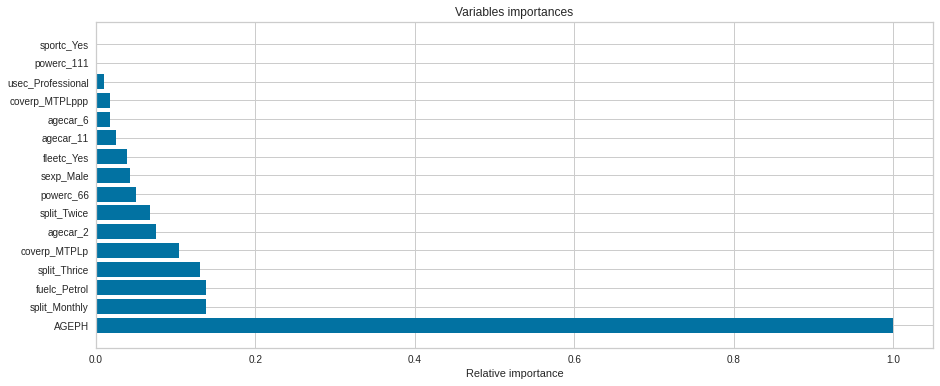

In [ ]:
# Features' names
features = list(X_train_2)

# Importance measures
importances = reg_rf.feature_importances_

# We sort the features by highest importance
indices = np.flip(np.argsort(importances))


#Plot
plt.title('Variables importances')
plt.barh(range(len(indices)), importances[indices] / importances[indices[0]], color = 'b', align = 'center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative importance')
plt.show()

The AGEPH variable is the most important feature globally.

PDP


We will see below the marginal effect of some variables from the model with PDP. We look at the AGEPH that is the most important one and others variables.

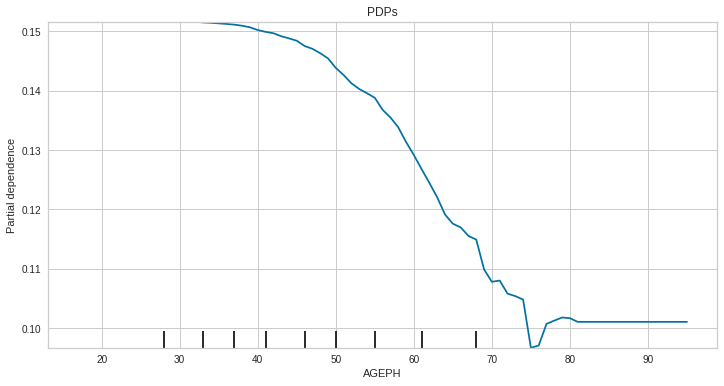

In [ ]:
# PDPs for XGBoost model
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("PDPs")


PartialDependenceDisplay.from_estimator(reg_rf, X=X_train_2,features = ['AGEPH'], ax=ax);

The prediction from the model gives higher loss frequency for younger policy holder age until ~ 80 years . After 80 years old, the prediction gets a little bit higher

<Figure size 1080x432 with 0 Axes>

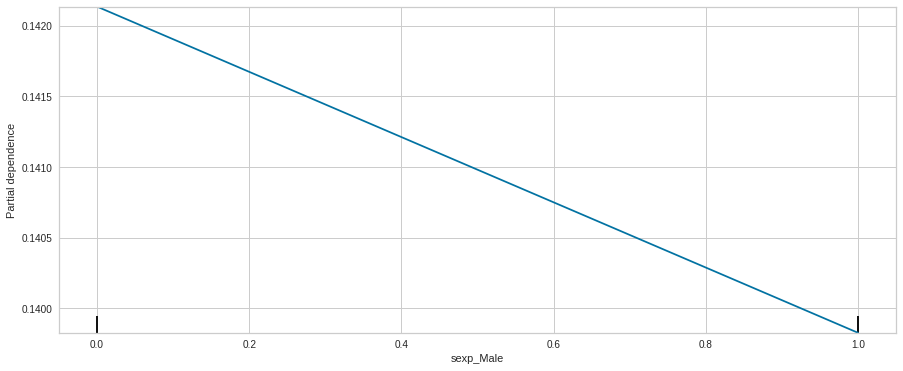

In [ ]:
features = ["sexp_Male"]
plt.figure()
display = PartialDependenceDisplay.from_estimator(
       reg_rf, X_train_2, features,kind='average', subsample=100,
       n_jobs=3, grid_resolution=40, method='brute',random_state=2,response_method='auto'
)
plt.show()

the prediction for female drivers gets a little bit higher frequency

Below we will look at the ICE plot for the AGEPH variable.  We will be  looking  at the evolution of the prediction for each observation separately along  AGEPH variable. We see that the trend for each curves is quite similar.

<Figure size 5760x5040 with 0 Axes>

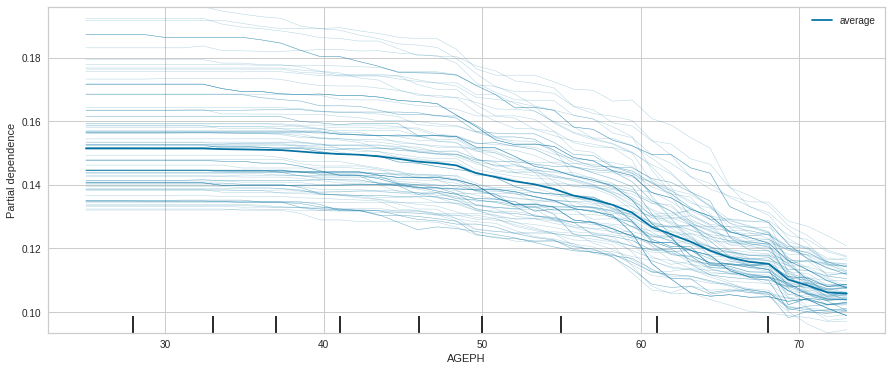

In [ ]:
features = ['AGEPH']
plt.figure(figsize=(80,70))
display = PartialDependenceDisplay.from_estimator(
       reg_rf, X_train_2, features,kind='both', subsample=100,
       n_jobs=3, grid_resolution=40, random_state=2,method='brute',response_method='auto'
)
plt.show()


##### Local Interpretability

We took some  policies from cluster 0 in order to get an idea of an explanation of the prediction for these particular cases. We saw that AGEPH is the most important feature . The sex and fuel type seems to have an importance (but lower than AGEPH). We expected that because it's from cluster 0 ~> see end of section Clustering). 

In [ ]:
cluster_train2[cluster_train2==0]

28997    0
25259    0
18015    0
275      0
15439    0
        ..
17702    0
22468    0
27432    0
37183    0
30136    0
Name: Clusters, Length: 31983, dtype: int64

In [ ]:
X_train_np=X_train_2.to_numpy(copy=True)
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_np, 
                                                   mode='regression',
                                                   feature_names=X_train_2.columns,
                                                   verbose=True)

In [ ]:
exp = explainer.explain_instance(X_train_np[30136], reg_rf.predict, num_features=20)
exp.show_in_notebook(show_table=True)

Intercept 0.1309135065933691
Prediction_local [0.14915304]
Right: 0.14406048718966524


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


In [ ]:
exp = explainer.explain_instance(X_train_np[28997], reg_rf.predict, num_features=20)
exp.show_in_notebook(show_table=True)

Intercept 0.11181958541793538
Prediction_local [0.16009289]
Right: 0.16035490735933486


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


We took two observations from cluster 0 and we saw that for the two observations, the variable AGEPH is important ( we saw in the part Global Interpretability that this variable is important). And we also noticed that the fuelc_Petrol is also a little bit important.

In [ ]:
explainer = shap.Explainer(reg_rf)
explainer.expected_value = explainer.expected_value[0]
shap_values = explainer(X_train_2)

For these two observations that we analized with LIME , we will also use the SHAP values to understand more what happened. The waterfall plot shows features each contributing to push the model output from the base value (the average model output $𝐸_𝑋[𝑓(𝑋)]$) to the model output ($𝑓(𝑥)$). Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. We notice that the AGE and FUELC variables are the two most important variables in these two cases.

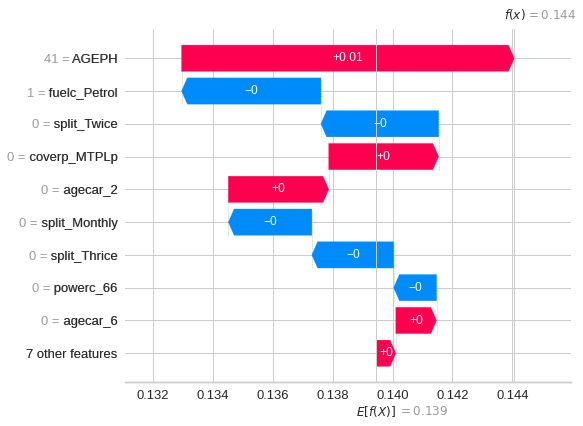

In [ ]:

shap.initjs()
shap.plots.waterfall(shap_values[30136])

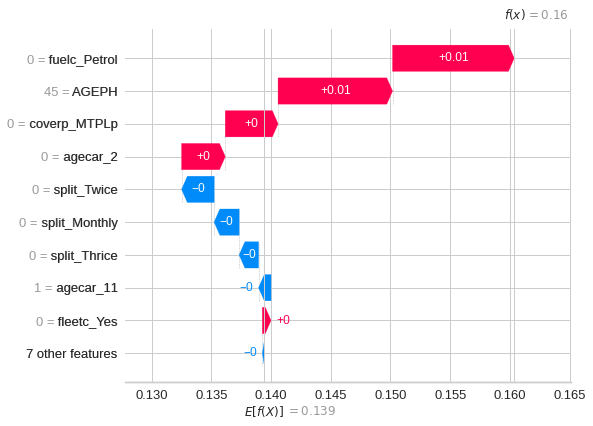

In [ ]:
shap.initjs()
shap.plots.waterfall(shap_values[28997])

We visualise differently the same explanation by a force plot

In [ ]:
shap.initjs()
shap.plots.force(shap_values[30136])


In [ ]:
shap.initjs()
shap.plots.force(shap_values[28997])

The plot below represents the change in predicted frequency as `AGEPH` changes. To help reveal these interactions, we color by `fuelC_Petrol`. It seems that there is not a particular interaction between these two variables

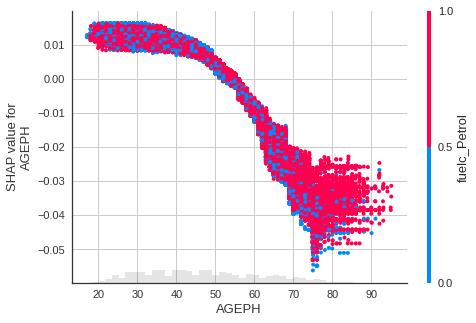

In [ ]:
shap.initjs()
shap.plots.scatter(shap_values[:, 'AGEPH'], color=shap_values[:,'fuelc_Petrol'])

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. In this plot we see that if the AGEPH is low it seems to get higher frequency.

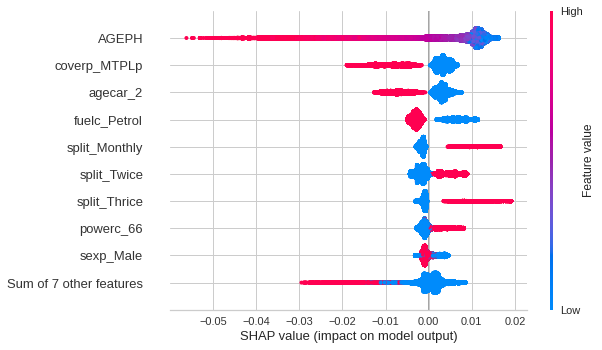

In [ ]:
shap.plots.beeswarm(shap_values)

We plot the mean absolute value of the SHAP values for each feature to get a standard bar plot

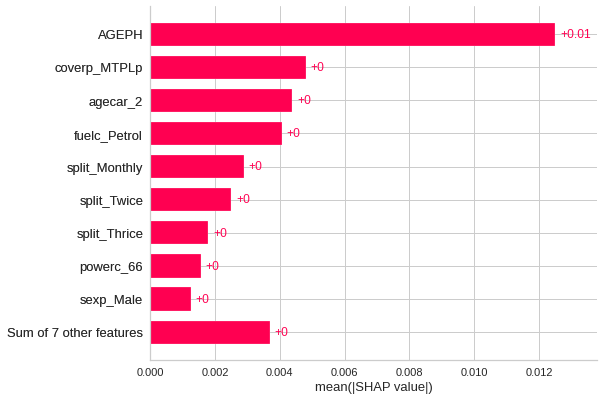

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
shap_interaction = explainer.shap_interaction_values(X_train_2)

Random Forest prediction for the 28997 observation : 0.16035490735933486
Mean prediction + sum of Shap interaction values for the 28997observation: 0.16128189666097129
Ageph contribution in the 28997 observation : 0.009580740568068999


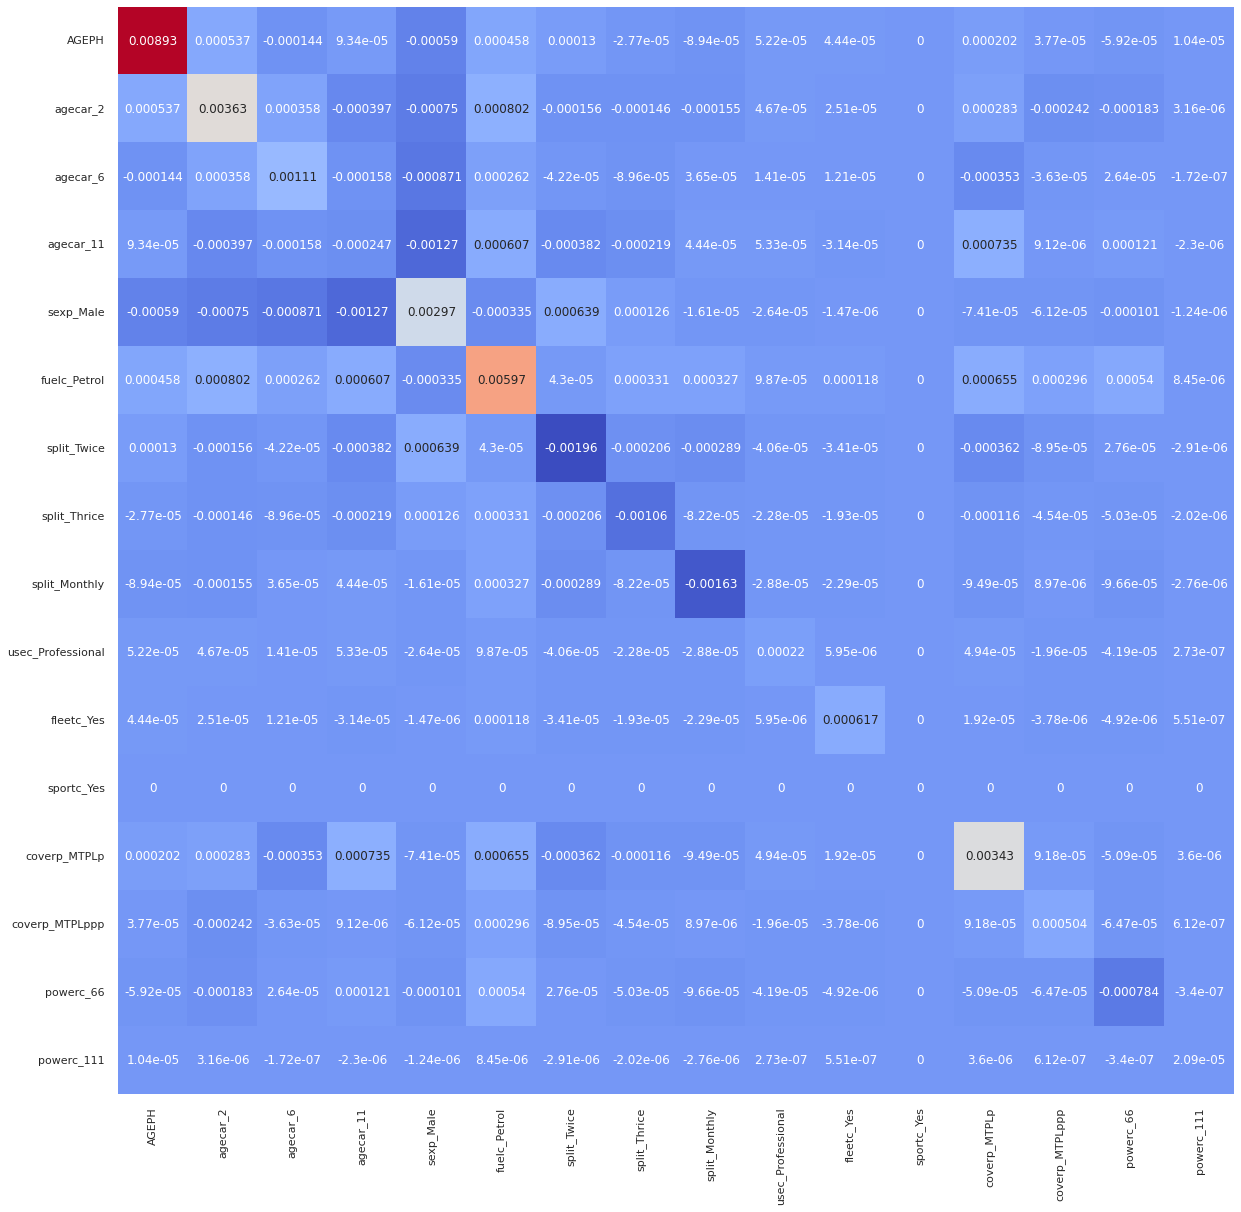

In [ ]:
df=pd.DataFrame(shap_interaction[28997],index=X_train_2.columns,columns=X_train_2.columns)

#Calculate mean prediction 
mean_pred = np.mean(y_pred_train)
#Sum of interaction values for first observation
sum_shap_matrix = np.sum(shap_interaction[28997])

#Check Shap Interaction Decomposition
print("Random Forest prediction for the 28997 observation : {}".format(y_pred_train[28997]))
print("Mean prediction + sum of Shap interaction values for the 28997observation: {}".format(mean_pred+sum_shap_matrix))
print("Ageph contribution in the 28997 observation : {}".format(df.values[0].sum()))

#Display 
plt.figure(figsize=(20, 20), facecolor='w', edgecolor='k')
sns.set(font_scale=1)
sns.heatmap(df,cmap='coolwarm',annot=True,fmt='.3g',cbar=False)
plt.show()

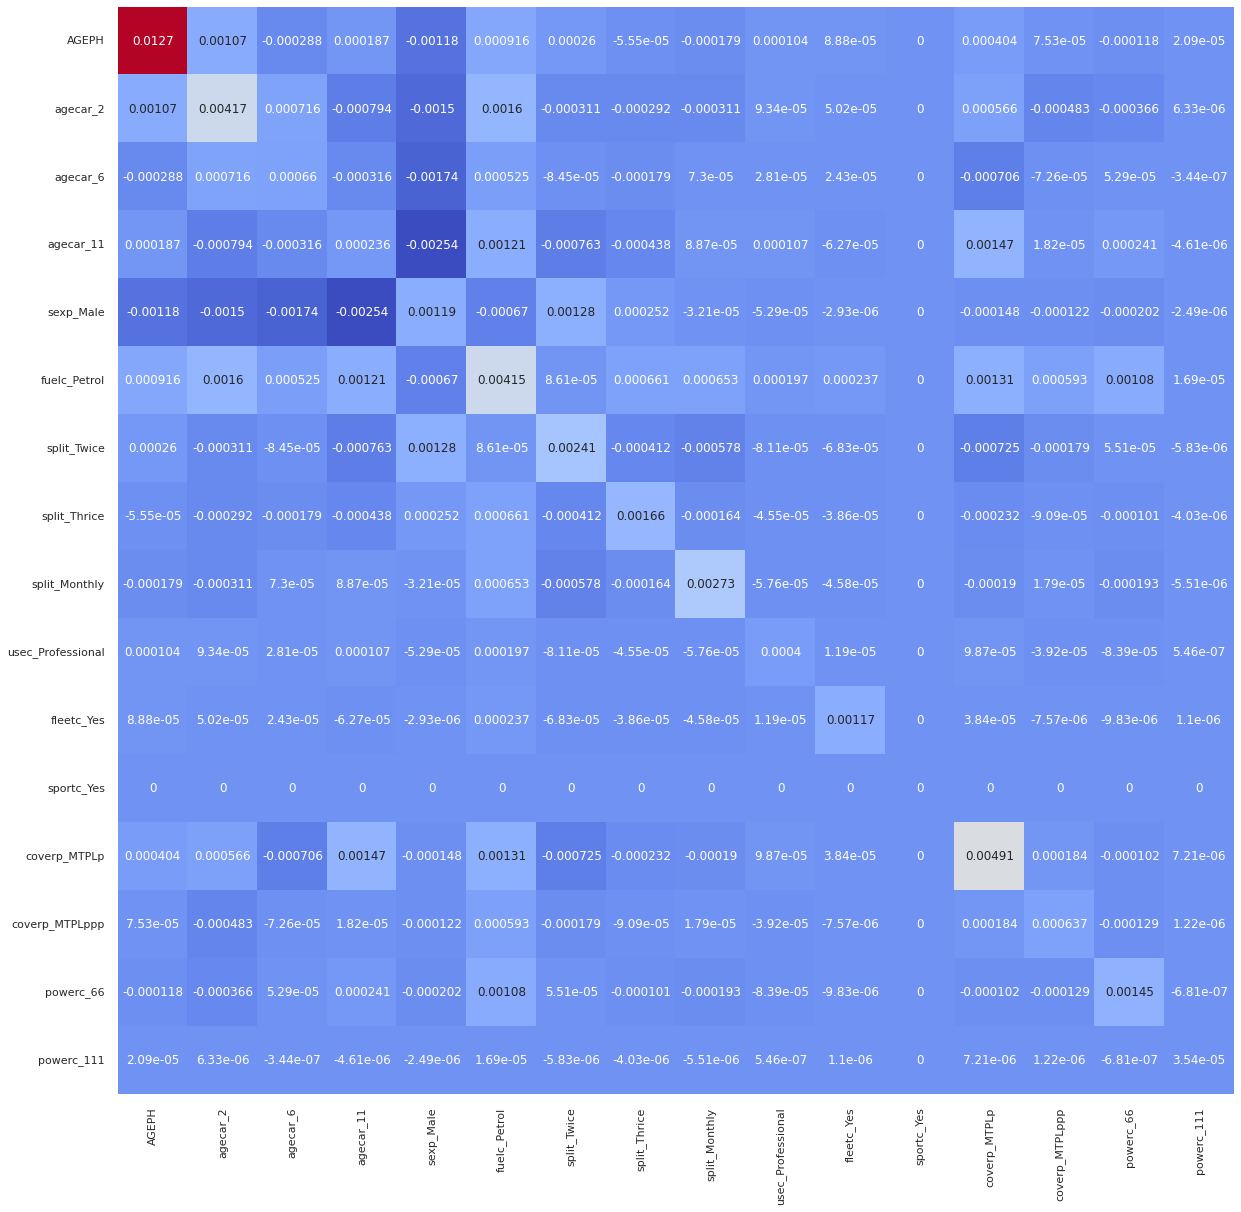

In [ ]:
mean_shap = np.abs(shap_interaction).mean(0)
df1 = pd.DataFrame(mean_shap,index=X_train_2.columns,columns=X_train_2.columns)
#df=df.iloc[[1,2,8,9,10],[1,2,8,9,10]]
# times by 2 (off diagonal only)
df1.where(df1.values == np.diagonal(df1),df.values*2,inplace=True)

# display 
plt.figure(figsize=(20, 20), facecolor='w', edgecolor='k')
sns.set(font_scale=1)
sns.heatmap(df1,cmap='coolwarm',annot=True,fmt='.3g',cbar=False)
plt.show()

We display the summary plot

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


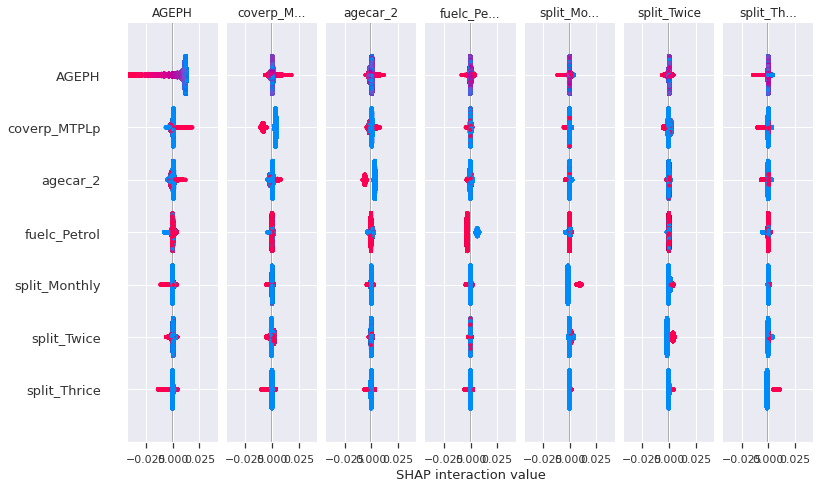

In [ ]:
shap.summary_plot(shap_interaction, X_train_2)

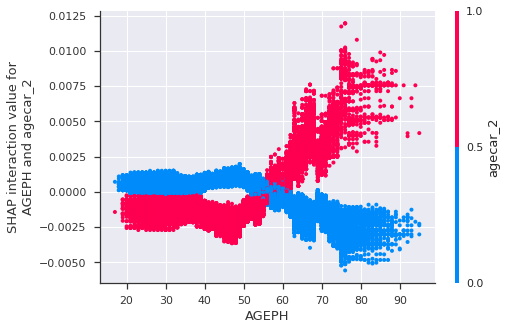

In [ ]:
shap.dependence_plot(("AGEPH","agecar_2"),shap_interaction, X_train_2,display_features=X_train_2)